In [104]:
from matplotlib import pyplot as plt
import numpy as np
from copy import copy, deepcopy
import seaborn as sns

sns.set()

In [105]:
def grad_descent_v2(f, df, low=None, high=None, callback=None):
    """ 
    Реализация градиентного спуска для функций с несколькими локальным минимумами,
    но с известной окрестностью глобального минимума. 
    Все тесты будут иметь такую природу.
    :param func: float -> float — функция 
    :param deriv: float -> float — её производная
    :param low: float — левая граница окрестности
    :param high: float — правая граница окрестности
    :param callback: callalbe -- функция логирования
    """
    def find_local_min(f, df, low_local, high_local, iters=5000, lr=0.05):
        #функция для нахождения минимума функции f на промежутке (low_local, high_local)
        x0 = np.random.uniform(low_local, high_local)
        x = low_local
        print(low_local, high_local)
        for i in range(iters):
            #YOUR CODE. Don't forget to clip x to [low_local, high_local]
            x = np.clip(x, low, high)
            x = x - df(x) * (lr / np.sqrt(iters))
            

        callback(x, f(x))
        return x


    # вам нужно запустить find_local_min несколько раз с разными границами и среди полученных ответов выбрать тот, при котором f имеет наименьшее значение 
    # подсказка: np.argmin
    number_of_decompose = 8
    set_of_x = np.linspace(low, high, number_of_decompose)
    set_of_min = []
    append_set_of_min = set_of_min.append
    for i in range(0, number_of_decompose - 1):
        append_set_of_min(find_local_min(f, df, set_of_x[i], set_of_x[i + 1]))
        
    print()
    # Разбейте отрезок [low,high] на 3-6 равных частей 
    # Для каждой части запустите find_local_min несколько 
    # (преподавательский код запускает 10) раз
    best_estimate = set_of_min[np.argmin(set_of_min)] #Найдите общий минимум по всем запускам. Возможно, вы захотите 
    #использовать np.argmin
    return best_estimate

In [106]:
def plot_convergence_1d(func, x_steps, y_steps, ax, grid=None, title=""):
    """
    Функция отрисовки шагов градиентного спуска. 
    Не меняйте её код без необходимости! 
    :param func: функция, которая минимизируется градиентным спуском
    :param x_steps: np.array(float) — шаги алгоритма по оси Ox
    :param y_steps: np.array(float) — шаги алгоритма по оси Оу
    :param ax: холст для отрисовки графика
    :param grid: np.array(float) — точки отрисовки функции func
    :param title: str — заголовок графика
    """
    ax.set_title(title, fontsize=16, fontweight="bold")

    if grid is None:
        grid = np.linspace(np.min(x_steps), np.max(x_steps), 100)

    fgrid = [func(item) for item in grid]
    ax.plot(grid, fgrid)
    yrange = np.max(fgrid) - np.min(fgrid)

    arrow_kwargs = dict(linestyle="--", color="grey", alpha=0.4)
    for i, _ in enumerate(x_steps):
        if i + 1 < len(x_steps):
            ax.arrow(
                x_steps[i], y_steps[i], 
                x_steps[i + 1] - x_steps[i],
                y_steps[i + 1] - y_steps[i], 
                **arrow_kwargs
            )

    n = len(x_steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(x_steps, y_steps, c=color_list)
    ax.scatter(x_steps[-1], y_steps[-1], c="red")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")


class LoggingCallback:
    """
    Класс для логирования шагов градиентного спуска. 
    Сохраняет точку (x, f(x)) на каждом шаге.
    Пример использования в коде: callback(x, f(x))
    """
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)


def test_convergence_1d(grad_descent, test_cases, tol=1e-2, axes=None, grid=None):
    """
    Функция для проверки корректности вашего решения в одномерном случае.
    Она же используется в тестах на Stepik, так что не меняйте её код!
    :param grad_descent: ваша реализация градиентного спуска
    :param test_cases: dict(dict), тесты в формате dict с такими ключами:
        - "func" — функция (обязательно)
        - "deriv" — её производная (обязательно)
        - "start" — начальная точка start (м.б. None) (опционально) 
        - "low", "high" — диапазон для выбора начальной точки (опционально)
        - "answer" — ответ (обязательно)
    При желании вы можете придумать и свои тесты.
    :param tol: предельное допустимое отклонение найденного ответа от истинного
    :param axes: матрица холстов для отрисовки, по ячейке на тест
    :param grid: np.array(float), точки на оси Ох для отрисовки тестов
    :return: флаг, корректно ли пройдены тесты, и дебажный вывод в случае неудачи
    """
    right_flag = True
    debug_log = []
    for i, key in enumerate(test_cases.keys()):
        # Формируем входные данные и ответ для алгоритма.
        answer = test_cases[key]["answer"]
        test_input = deepcopy(test_cases[key])
        del test_input["answer"]
        # Запускаем сам алгоритм.
        callback = LoggingCallback()  # Не забываем про логирование
        res_point = grad_descent(*test_input.values(), callback=callback)
        # Отрисовываем результаты.
        if axes is not None:
            ax = axes[np.unravel_index(i, shape=axes.shape)]
            x_steps = np.array(callback.x_steps)
            y_steps = np.array(callback.y_steps)
            plot_convergence_1d(
                test_input["func"], x_steps, y_steps, 
                ax, grid, key
            )
            ax.axvline(answer, 0, linestyle="--", c="red",
                        label=f"true answer = {answer}")
            ax.axvline(res_point, 0, linestyle="--", c="xkcd:tangerine", 
                        label=f"estimate = {np.round(res_point, 3)}")
            ax.legend(fontsize=16)
        # Проверяем, что найдення точка достаточно близко к истинной
        if abs(answer - res_point) > tol or np.isnan(res_point):
            debug_log.append(
                f"Тест '{key}':\n"
                f"\t- ответ: {answer}\n"
                f"\t- вывод алгоритма: {res_point}"
            )
            right_flag = False
    return right_flag, debug_log

-4.0 -3.142857142857143
-3.142857142857143 -2.2857142857142856
-2.2857142857142856 -1.4285714285714288
-1.4285714285714288 -0.5714285714285716
-0.5714285714285716 0.2857142857142856
0.2857142857142856 1.1428571428571423
1.1428571428571423 2.0

-3.0 -2.142857142857143
-2.142857142857143 -1.2857142857142858
-1.2857142857142858 -0.4285714285714288
-0.4285714285714288 0.4285714285714284
0.4285714285714284 1.2857142857142856
1.2857142857142856 2.1428571428571423
2.1428571428571423 3.0

-2.0 -1.4285714285714286
-1.4285714285714286 -0.8571428571428572
-0.8571428571428572 -0.2857142857142858
-0.2857142857142858 0.2857142857142856
0.2857142857142856 0.8571428571428568
0.8571428571428568 1.4285714285714284
1.4285714285714284 2.0

0.0 0.2857142857142857
0.2857142857142857 0.5714285714285714
0.5714285714285714 0.8571428571428571
0.8571428571428571 1.1428571428571428
1.1428571428571428 1.4285714285714284
1.4285714285714284 1.7142857142857142
1.7142857142857142 2.0

-4.0 -3.7142857142857144
-3.71428

C:\Users\Vadim\AppData\Local\Temp/ipykernel_11792/179562656.py:23: RuntimeWarning: invalid value encountered in sqrt
  "func" : lambda x: 5 * np.abs(x)/x**2 - 0.5 * x + 0.1 * np.sqrt(-x) + 0.01 * x**2 ,


Не сошлось. Дебажный вывод:
Тест 'poly2':
	- ответ: 0.352
	- вывод алгоритма: -1.8263205369387823
Тест 'another yet poly':
	- ответ: 1.24829
	- вывод алгоритма: -1.2187588596808874
Тест '|x|/x^2 - x + sqrt(-x) + (even polynom)':
	- ответ: -2.91701
	- вывод алгоритма: -3.273008304514655


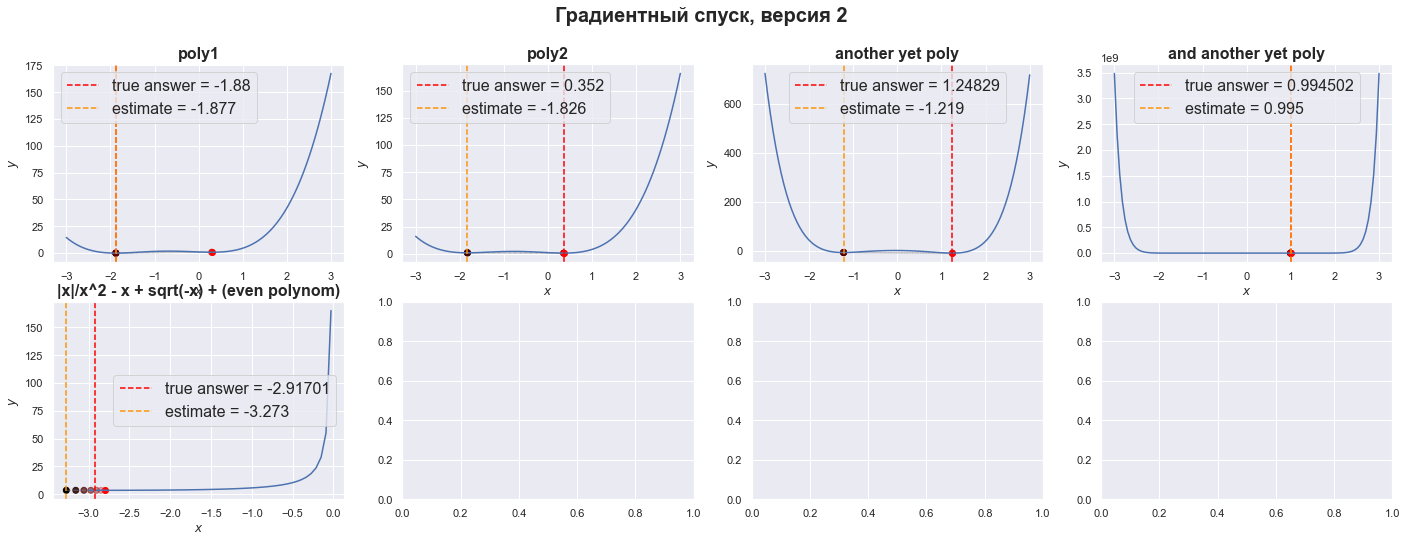

In [102]:
test_cases = {
    "poly1" : {
        "func" : lambda x: x**4 + 3 * x**3 + x**2 - 1.5 * x + 1,
        "deriv" : lambda x: 4 * x**3 + 9 * x**2 + 2 * x - 1.5,
        "low" : -4, "high" : 2, "answer" : -1.88
    },
    "poly2" : {
        "func" : lambda x: x**4 + 3 * x**3 + x**2 - 2 * x + 1.0,
        "deriv" : lambda x: 4 * x**3 + 9 * x**2 + 2 * x - 2.0, 
        "low" : -3, "high" : 3, "answer" : 0.352
    },
    "another yet poly" : {
        "func" : lambda x: x**6 + x**4 - 10 * x**2 - x ,
        "deriv" : lambda x: 6 * x**5 + 4 * x**3 - 20 * x - 1, 
        "low" : -2, "high" : 2, "answer" : 1.24829
    },
    "and another yet poly" : {
        "func" : lambda x: x**20 + x**2 - 20 * x + 10,
        "deriv" : lambda x: 20 * x**19 + 2 * x - 20, 
        "low" : -0, "high" : 2, "answer" : 0.994502
    },
    "|x|/x^2 - x + sqrt(-x) + (even polynom)" : {
        "func" : lambda x: 5 * np.abs(x)/x**2 - 0.5 * x + 0.1 * np.sqrt(-x) + 0.01 * x**2 ,
        "deriv" : lambda x: -0.5 - 0.05/np.sqrt(-x) + 0.02 * x + 5/(x * np.abs(x)) - (10 * np.abs(x))/x**3,
        "low" : -4, "high" : -2, "answer" : -2.91701
    },
}

tol = 1e-2 # желаемая точность

fig, axes = plt.subplots(2,4, figsize=(24, 8))
fig.suptitle("Градиентный спуск, версия 2", fontweight="bold", fontsize=20)
grid = np.linspace(-3, 3, 100)

is_correct, debug_log = test_convergence_1d(
    grad_descent_v2, test_cases, tol, 
    axes, grid
)

if not is_correct:
    print("Не сошлось. Дебажный вывод:")
    for log_entry in debug_log:
        print(log_entry)

In [103]:
x = np.linspace(5, 10, 5)
print(x)

[ 5.    6.25  7.5   8.75 10.  ]
